In [423]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_rows", 20, "display.max_columns", 10)

In [405]:
import hytools as ht
import numpy as np

def get_spectral_data_and_wavelengths(filename, row_step, col_step):
    """
    Retrieve spectral data and wavelengths from a specified file using HyTools library.

    Parameters:
    - filename: str, the path to the file to be read.
    - row_step: int, the step size to sample rows by.
    - col_step: int, the step size to sample columns by.

    Returns:
    - original: np.ndarray, a 2D array where each row corresponds to the spectral data from one pixel.
    - wavelengths: np.ndarray, an array containing the wavelengths corresponding to each spectral band.
    """
    # Initialize the HyTools object
    envi = ht.HyTools()
    
    # Read the file using the specified format
    envi.read_file(filename, 'envi')
    
    # Define the row and column ranges
    rowrange = np.arange(0, round(envi.lines, -3), row_step).tolist()  # Adjusted to use envi.lines for dynamic range
    colrange = np.arange(0, round(envi.columns, -3), col_step).tolist()  # Adjusted to use envi.columns for dynamic range
    
    # Retrieve the pixels' spectral data
    original = envi.get_pixels(rowrange, colrange)

    #original = pd.DataFrame(envi.get_pixels(rowrange, colrange))
    #original['index'] = np.arange(original.shape[0])
    
    # Also retrieve the wavelengths
    wavelengths = envi.wavelengths
    
    return original, wavelengths

filename="export/ENVI__corrected_0"
#filename =  "export/resample_landsat5"
spectral_data, wavelengths = get_spectral_data_and_wavelengths(filename, row_step, col_step)
pd.DataFrame(spectral_data)
#wavelengths

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
422,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
423,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
424,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [428]:
envi = ht.HyTools()
filename =  "export/resample_landsat5"
    # Read the file using the specified format
envi.read_file(filename, 'envi')
    
    # Define the row and column ranges
rowrange = np.arange(0, round(envi.lines, -3), row_step).tolist()  # Adjusted to use envi.lines for dynamic range
colrange = np.arange(0, round(envi.columns, -3), col_step).tolist()  # Adjusted to use envi.columns for dynamic range
    
    # Retrieve the pixels' spectral data
original = envi.get_pixels(rowrange, colrange)
original = pd.DataFrame(envi.get_pixels(rowrange, colrange))
original['index'] = np.arange(original.shape[0])


long_df = pd.melt(pd.DataFrame(original), var_name="wavelength_nm", value_name="reflectance", id_vars="index")
pd.DataFrame(long_df).tail(100)


,index,wavelength_nm,reflectance
5900,900,5,-9998.833896
5901,901,5,-9998.833896
5902,902,5,-9998.833896
5903,903,5,-9998.833896
5904,904,5,-9998.833896
...,...,...,...
5995,995,5,-9998.833896
5996,996,5,-9998.833896
5997,997,5,-9998.833896
5998,998,5,-9998.833896


In [395]:
filenames = [
    "export/resample_landsat5",
    "export/resample_landsat7",
    "export/resample_landsat8",
    "export/resample_landsat9.img",
    "export/ENVI__corrected_0",
    "export/ENVI__corrected_0_mask"
]

# Initialize dictionary to store results
results = {}

row_step, col_step = 6, 1  # Define your steps here

# Loop through filenames
for filename in filenames:
    spectral_data, wavelengths = get_spectral_data_and_wavelengths(filename, row_step, col_step)
    results[filename] = {"spectral_data": spectral_data, "wavelengths": wavelengths}

# Now, results contain spectral data and wavelengths for each file
#results

In [407]:
def access_or_prepare_data(results, index):
    keys = list(results.keys())
    if index < 0 or index >= len(keys):
        print("Index out of range")
        return None

    first_key = keys[index]
    spectral_data = results[first_key]['spectral_data']
    wavelengths = results[first_key]['wavelengths']

    if index < 4:
        df_spectral_data = pd.DataFrame(spectral_data, columns=wavelengths.astype(str))
        long_df = pd.melt(df_spectral_data, var_name="wavelength_nm", value_name="reflectance")
        waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
        waves['band'] = range(len(waves))
        long_df["wavelength_nm"] = pd.to_numeric(long_df["wavelength_nm"])
        merged_data = pd.merge(long_df, waves, on='wavelength_nm')
        # Add a label column to the merged data
        first_key = keys[index].replace("export/resample_", "")  # Modified here to remove "export/"
        merged_data['sensor'] = first_key
        merged_data = merged_data.reindex(columns=['sensor', 'band', 'wavelength_nm', 'reflectance','index'])
        return merged_data
    else:
        merged_data = prepare_spectral_data(spectral_data, wavelengths)
        # Add a label column to the merged data
        first_key = keys[index].replace("export/ENVI__corrected_0", "hyperspectral")  # Modified here to remove "export/"
        merged_data['sensor'] = first_key
        merged_data = merged_data.reindex(columns=['sensor', 'band', 'wavelength_nm', 'reflectance','index'])
        return merged_data

access_or_prepare_data(results, 2)

,sensor,band,wavelength_nm,reflectance,index
0,landsat8,0,480.0,-9999.000000,NaN
1,landsat8,0,480.0,-9999.000000,NaN
2,landsat8,0,480.0,-9999.000000,NaN
3,landsat8,0,480.0,-9999.000000,NaN
4,landsat8,0,480.0,-9999.000000,NaN
...,...,...,...,...,...
5995,landsat8,5,2200.0,-9998.999351,NaN
5996,landsat8,5,2200.0,-9998.999351,NaN
5997,landsat8,5,2200.0,-9998.999351,NaN
5998,landsat8,5,2200.0,-9998.999351,NaN


In [454]:
# Replace 'results' with your actual dictionary variable
prepared_or_accessed_data = access_or_prepare_data(results, 4)
prepared_or_accessed_data = pd.DataFrame(prepared_or_accessed_data)
length = len(prepared_or_accessed_data)
sequence = np.arange(0, 1000)  # Creates an array [1, 2, ..., 999]
repeated_sequence = np.resize(sequence, length)  # Resize the sequence to match the DataFrame's length

prepared_or_accessed_data['index'] = repeated_sequence  # Add the column to your DataFrame

# Now, 'prepared_or_accessed_data' contains the data you need
prepared_or_accessed_data.tail(430)


,sensor,band,wavelength_nm,reflectance,index
425570,hyperspectral,425,2509.728027,2380.0,570
425571,hyperspectral,425,2509.728027,1511.0,571
425572,hyperspectral,425,2509.728027,320.0,572
425573,hyperspectral,425,2509.728027,1194.0,573
425574,hyperspectral,425,2509.728027,82.0,574
...,...,...,...,...,...
425995,hyperspectral,425,2509.728027,-9999.0,995
425996,hyperspectral,425,2509.728027,-9999.0,996
425997,hyperspectral,425,2509.728027,-9999.0,997
425998,hyperspectral,425,2509.728027,-9999.0,998


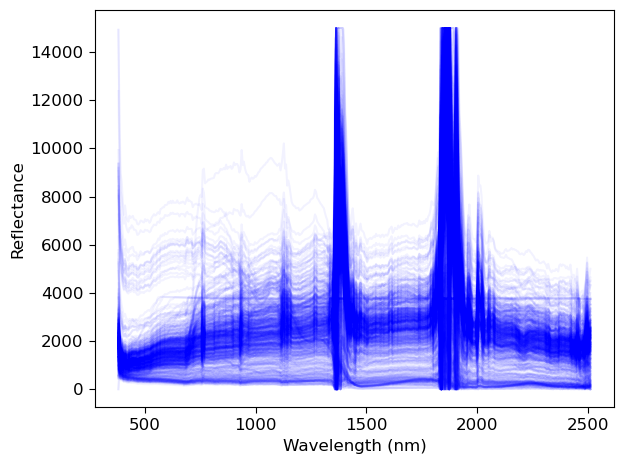

In [455]:
def plot_spectral_data(df):
    # Replace -9999 values with NaN
    df['reflectance'] = df['reflectance'].replace(-9999, np.nan)
    
    unique_indices = df['index'].unique()  # Consider limiting the unique indices if needed
    
    for idx in unique_indices:
        subset = df[df['index'] == idx]
        plt.plot(subset['wavelength_nm'], subset['reflectance'], label=f'Index {idx}', alpha=0.05, color="blue")
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.tight_layout()
    plt.show()

# Example usage
plot_spectral_data(prepared_or_accessed_data)

